# UT Transformers project: multivariate Time-series Deep Encoder on one segment, default vs optimized with Optuna

Enefit Energy consumption/production using one segment. Use the Kaggle predict-energy-behaviour-of-prosumers dataset.

GPU should be enabled to run this notebook. Otherwise it will be very slow.

# 1. Libraries

In this notebook, we can pip install libraries because internet is enabled. To submit a notebook to a competition, the internet has to be disabled. In that case, it is possible to import libraries via a utility script.

In [1]:
!pip install -qq darts

In [2]:
!pip install --quiet torch>=1.10.0 torchvision>=0.11.0 pytorch-lightning==1.9.0 torchmetrics==0.9.3 timm optuna==2.10.1

In [3]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)
import torch
import random

from tqdm.notebook import tqdm
from pytorch_lightning.callbacks import Callback, EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import os
import warnings
from timeit import default_timer as timer

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import polars

import torch
from torch import nn

from darts import TimeSeries
from darts.models import TiDEModel, TFTModel, TransformerModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import fill_missing_values
from darts.metrics import mae

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


# 2. Data preparation

The features to predict the electricity produced and consumed include historical real and forecasted weather data, gas and electricity prices, and data about the prosumers, including their installed photovoltaic capacity. The detailed data descriptions are available on [the competition data page](https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers/data).

Credits for data preparation: https://www.kaggle.com/code/greysky/enefit-darts-study-notes

In [5]:
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target):    
    df_data = (
        df_data
        .join(df_target, on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
    )
    
    df_consume = (
        df_data
        .filter(polars.col("is_consumption").eq(1))
        .select("target", "county", "is_business", "product_type", "datetime")
    )

    df_data = (
        df_data
        .filter(polars.col("is_consumption").eq(0))
        .join(df_consume, on=["county", "is_business", "product_type", "datetime"], how="left")
        .rename({"target": "production", "target_right": "consumption"})
        .with_columns(polars.col("datetime").cast(polars.Date).alias("date"))
        .drop("is_consumption")
    )
    
    df_client = (
        df_client
        .with_columns((polars.col("date") + polars.duration(days=2)).cast(polars.Date))
    )
    
    df_gas = (
        df_gas
        .rename({"forecast_date": "date"})
        .with_columns((polars.col("date") + polars.duration(days=1)).cast(polars.Date))
    )

    df_electricity = (
        df_electricity
        .rename({"forecast_date": "datetime"})
        .with_columns(datetime=polars.col("datetime") + polars.duration(days=1))
    )
    
    df_location = (
        df_location
        .with_columns(
            polars.col("latitude").cast(polars.datatypes.Float32),
            polars.col("longitude").cast(polars.datatypes.Float32)
        )
    )
    
    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            polars.col("latitude").cast(polars.datatypes.Float32),
            polars.col("longitude").cast(polars.datatypes.Float32),
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
        .with_columns(polars.col("county").fill_nan(12))
        .group_by("county", "datetime").mean()
    )
    
    df_data = (
        df_data
        .join(df_gas, on="date", how="left")
        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")
        .join(df_forecast, on=["county", "datetime"], how="left")
        .with_columns(
            polars.col(polars.Float64).cast(polars.Float32),
        )
        .drop("date")
    )
    
    return df_data

In [6]:
def to_pandas(df):
    df = df.to_pandas()
    df = df.set_index("row_id")
    
    return df

In [7]:
root = "/kaggle/input/predict-energy-behavior-of-prosumers"

data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'datetime']

In [8]:
df_data        = polars.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client      = polars.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas         = polars.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_cols, try_parse_dates=True)
df_electricity = polars.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_cols, try_parse_dates=True)
df_forecast    = polars.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_cols, try_parse_dates=True)
df_location    = polars.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), columns=location_cols, try_parse_dates=True)

df_target      = df_data.select(target_cols)
df_data        = df_data.drop("target")

df_data        = df_data.filter(polars.col("datetime").lt(pd.Timestamp("20230528")))
df_client      = df_client.filter(polars.col("date").lt(pd.Timestamp("20230526")))
df_gas         = df_gas.filter(polars.col("forecast_date").lt(pd.Timestamp("20230527")))
df_electricity = df_electricity.filter(polars.col("forecast_date").lt(pd.Timestamp("20230527")))
df_target      = df_target.filter(polars.col("datetime").lt(pd.Timestamp("20230526")))

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_target      = df_target.schema

In [9]:
df_train = feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target)
df_train = to_pandas(df_train)

df_train = df_train[df_train["consumption"].notnull()]
df_train = df_train[df_train["production"].notnull()]

In [10]:
# Remove old data
df_train = df_train[df_train['datetime'] > pd.to_datetime('2022-01-01 00:00:00')]

In [11]:
df_train.shape

(816478, 23)

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 816478 entries, 366178 to 1999534
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   county                             816478 non-null  int64         
 1   is_business                        816478 non-null  int64         
 2   product_type                       816478 non-null  int64         
 3   datetime                           816478 non-null  datetime64[ns]
 4   production                         816478 non-null  float32       
 5   consumption                        816478 non-null  float32       
 6   lowest_price_per_mwh               816478 non-null  float32       
 7   highest_price_per_mwh              816478 non-null  float32       
 8   eic_count                          815281 non-null  float64       
 9   installed_capacity                 815281 non-null  float32       
 10  euros_per_mwh      

# 3. One segment

In [13]:
def to_time_series(df_data, county, is_business, product_type):
    """Create a Darts time-series for one segment"""
    
    time_col   = "datetime"
    group_cols = ["county", "is_business", "product_type"]
    value_cols = ["production", "consumption", "lowest_price_per_mwh", "highest_price_per_mwh", "eic_count", "installed_capacity", "euros_per_mwh", 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
    
    df_data = df_data[
        df_data["county"].eq(county) &
        df_data["is_business"].eq(is_business) &
        df_data["product_type"].eq(product_type)
    ]
    
    ts = TimeSeries.from_dataframe(
        df_data,
        time_col=time_col,
        value_cols=value_cols,
        fill_missing_dates=True,
        freq="1h",
    )
        
    return ts

# 4. Train-val-test split

Currently not using cross-validation as it would be more time-consuming computation-wise. However, it could increase stability.

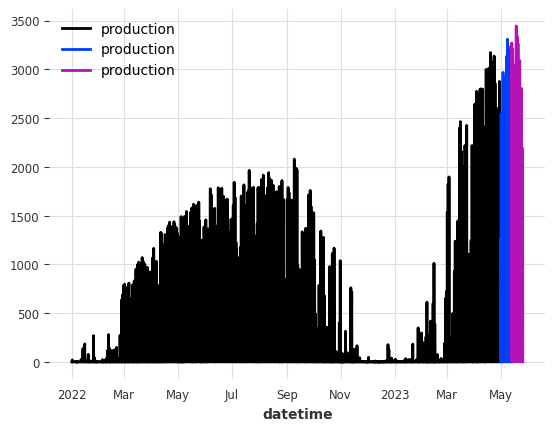

In [14]:
series = to_time_series(df_train, county=0, is_business=0, product_type=1)

# Fill Missing Values

series = fill_missing_values(series)

# Holidays

series = series.add_holidays("EE") # Estonian holidays

# Train / Test Split

train_series, temp = series.split_before(0.95)
val_series, test_series = temp.split_before(0.50)

train_series['production'].plot()
val_series['production'].plot()
test_series['production'].plot()
plt.show()

In [15]:
len(train_series), len(val_series), len(test_series)

(11626, 306, 307)

In [16]:
len(val_series)-(7*24)

138

# 5. Common settings

In [19]:
# fixed parameters that will be the same for all models
SEED = 42
MAX_N_EPOCHS = 30 # Default in Darts for Vanilla, TiDE and TFT is 100
BATCH_SIZE = 128 # Default in Darts is 32
IN_LEN = 7*24 #  Number of time steps in the past to take as a model input (per chunk)
OUT_LEN = 2*24 # Number of time steps predicted at once (per chunk) by the internal model.
NR_EPOCHS_VAL_PERIOD = 1

In [20]:
# encoders
encoders={
'cyclic': {'future': ['hour', 'dayofyear']},
'datetime_attribute': {'future': ['hour', 'dayofweek']},
'position': {'past': ['relative'], 'future': ['relative']},
'transformer': Scaler(),
}

![Source: Darts documentation](https://unit8co.github.io/darts/_images/covariates-highlevel.png)

In [21]:
target_col = ["production", "consumption"]
past_covariates = ["lowest_price_per_mwh", "highest_price_per_mwh", "eic_count", "installed_capacity", "euros_per_mwh"]
future_covariates = ["holidays", "temperature", "dewpoint", "cloudcover_high", "cloudcover_mid", "cloudcover_low", "cloudcover_total", "total_precipitation", "surface_solar_radiation_downwards"]

train_target = train_series[target_col]
train_past_covariates = train_series[past_covariates]
train_future_covariates = train_series[future_covariates]

val_target = val_series[target_col]
val_past_covariates = val_series[past_covariates]
val_future_covariates = val_series[future_covariates]

test_target = test_series[target_col]
test_past_covariates = test_series[past_covariates]
test_future_covariates = test_series[future_covariates]

In [22]:
# We have to leave at least input chunk len to predict the first increment
prediction_len = len(val_target)-(IN_LEN)
prediction_len

138

As metric, we use MAE which is the official metric in the Kaggle competition.

In [23]:
def get_results(truth, preds):
    overall_MAE = mae(truth, preds)
    consumption_MAE = mae(truth['consumption'], preds['consumption'])
    production_MAE = mae(truth['production'], preds['production'])
    
    print('Overall MAE: ', overall_MAE)
    print('Consumption MAE: ', consumption_MAE)
    print('Production MAE: ', production_MAE)
    
    results_dict = {
    "overall_MAE": overall_MAE,
    "consumption_MAE": consumption_MAE,
    "production_MAE": production_MAE
    }
    
    return results_dict

In [24]:
all_results = {}

# 6. Time-series Dense Encoder (TiDE)

Uses multilayer perceptron (MLP)-based encoder-decoders without attention. TiDE is faster than transformers that use attention.

Default hyperparams: (input_chunk_length, output_chunk_length, num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, **kwargs)

https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tide_model.html

https://arxiv.org/pdf/2304.08424.pdf

Below is a snippet from the TiDE paper:

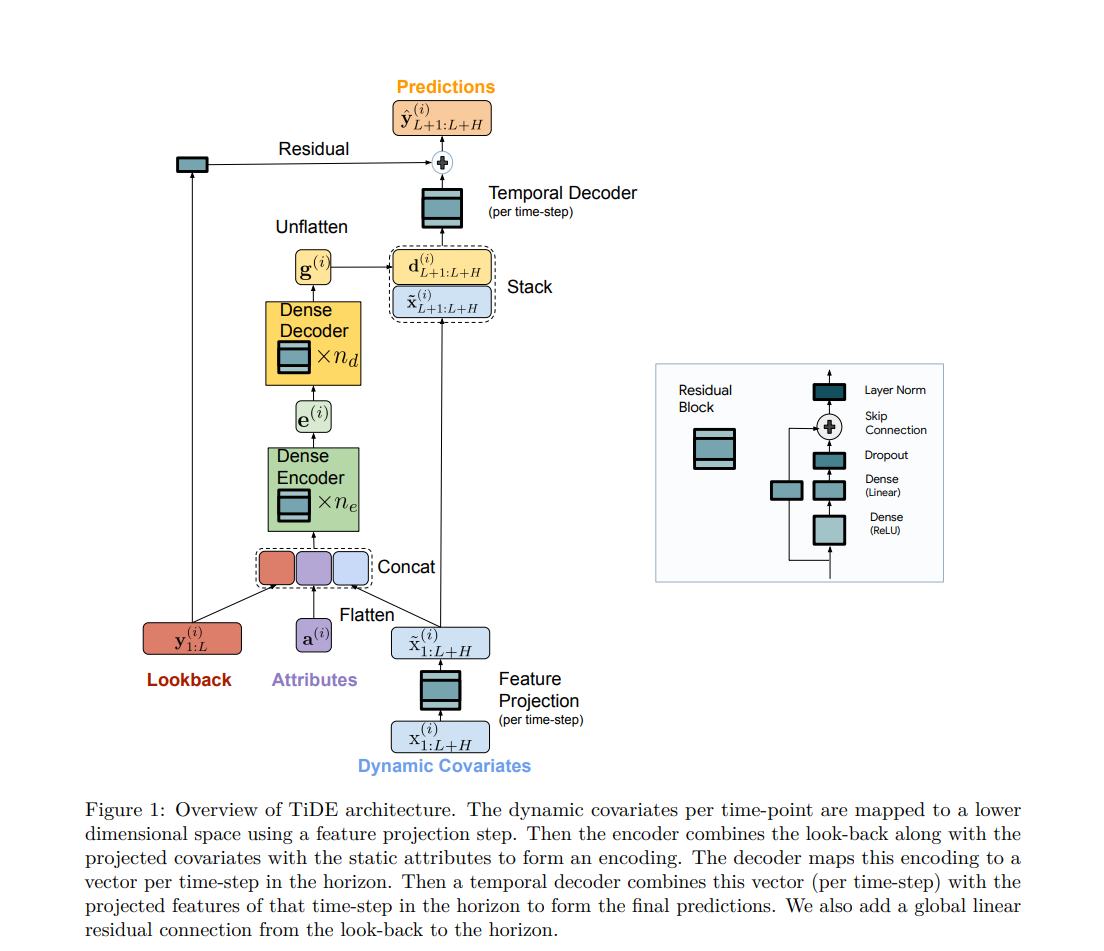

## 6.1 TiDE with default hyperparameters

Default hyperparams: (input_chunk_length, output_chunk_length, num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, **kwargs)

In [44]:
N_EPOCHS=100 # Max number of epochs, we will be using early stopping

In [45]:
# throughout training we'll monitor the validation loss for early stopping
early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
callbacks = [early_stopper]

# detect if a GPU is available
if torch.cuda.is_available():
    pl_trainer_kwargs = {
        "accelerator": "gpu",
        "devices": [0],
        "callbacks": callbacks,
    }
    num_workers = 4
else:
    pl_trainer_kwargs = {"callbacks": callbacks}
    num_workers = 0

In [46]:
model_TiDE = TiDEModel(
    input_chunk_length=IN_LEN,
    output_chunk_length=OUT_LEN,
    add_encoders=encoders,
    loss_fn=nn.L1Loss(),
    n_epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    random_state=SEED,
    pl_trainer_kwargs=pl_trainer_kwargs,
    model_name="tide_model",
    save_checkpoints=True,
    force_reset=True
)

start = timer()
model_TiDE.fit(
    series=train_target,
    past_covariates=train_past_covariates,
    future_covariates=train_future_covariates,
    val_series=val_target,
    val_past_covariates=val_past_covariates,
    val_future_covariates=val_future_covariates,
)

model_TiDE_best = model_TiDE.load_from_checkpoint("tide_model")

end = timer()
fitting_TiDE = end - start
print("Fitting Time:", round(fitting_TiDE, 2), "seconds")

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Fitting Time: 79.13 seconds


Predicting: 0it [00:00, ?it/s]

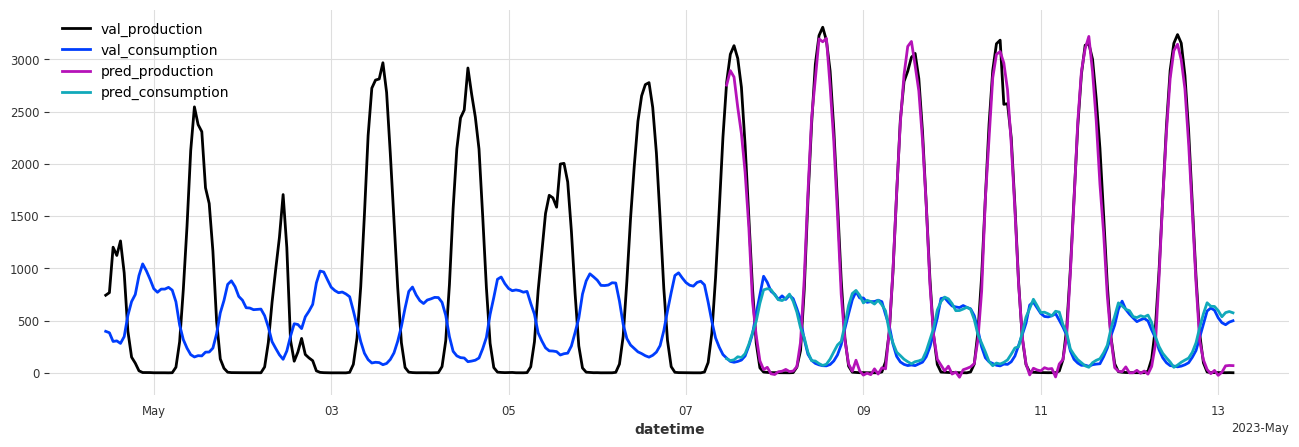

In [47]:
prediction = model_TiDE_best.predict(
    prediction_len, val_target[:-prediction_len],
    past_covariates=val_past_covariates,
    future_covariates=val_future_covariates,
)

plt.figure(figsize=(16, 5))

val_target.plot(label="val")
prediction.plot(label="pred")
plt.show()

In [48]:
all_results['TiDE_default'] = get_results(val_target[IN_LEN:], prediction)

Overall MAE:  53.35003618904331
Consumption MAE:  37.012054761686436
Production MAE:  69.68801761640017


Predicting: 0it [00:00, ?it/s]

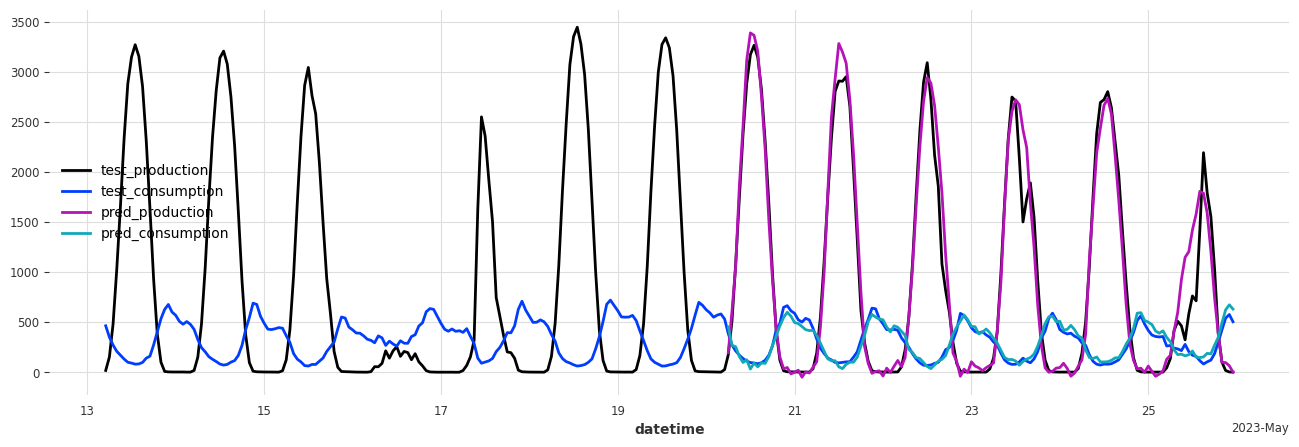

In [49]:
prediction = model_TiDE_best.predict(
    prediction_len, test_target[:-prediction_len],
    past_covariates=test_past_covariates,
    future_covariates=test_future_covariates,
)

plt.figure(figsize=(16, 5))

test_target.plot(label="test")
prediction.plot(label="pred")
plt.show()

In [50]:
all_results['TiDE_default_test'] = get_results(test_target[IN_LEN:], prediction)

Overall MAE:  88.02093471445012
Consumption MAE:  42.17396003284224
Production MAE:  133.867909396058


## 6.2 Optimizing TiDE with Optuna

For optimizing, we use the same hyperparameter ranges as presented in the TiDE paper.

In [25]:
def build_fit_tide_model(
    IN_LEN,
    num_encoder_layers,
    num_decoder_layers,
    decoder_output_dim,
    temporal_decoder_hidden,
    use_layer_norm,
    use_reversible_instance_norm,
    dropout,
    lr,
    likelihood=None,
    callbacks=None,
    encoders=encoders,
    batch_size=BATCH_SIZE,
    n_epochs=MAX_N_EPOCHS,
):

    # reproducibility
    torch.manual_seed(SEED)
    
    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "devices": [0],
            "callbacks": callbacks,
            "precision":64
        }
        num_workers = 4
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        num_workers = 0

    
    model_TiDE = TiDEModel(
        input_chunk_length=IN_LEN,
        output_chunk_length=OUT_LEN,
        add_encoders=encoders,
        loss_fn=nn.L1Loss(),
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        decoder_output_dim=decoder_output_dim,
        temporal_decoder_hidden=temporal_decoder_hidden,
        dropout=dropout,
        use_layer_norm=use_layer_norm,
        use_reversible_instance_norm=use_reversible_instance_norm,
        optimizer_kwargs={"lr": lr},
        batch_size=batch_size,
        n_epochs=n_epochs,
        random_state=42,
        model_name="tide_model",
        likelihood=likelihood,
        force_reset=True,
        save_checkpoints=True,
        pl_trainer_kwargs=pl_trainer_kwargs,
    )
    
    model_TiDE.fit(
        series=train_target,
        past_covariates=train_past_covariates,
        future_covariates=train_future_covariates,
        val_series=val_target,
        val_past_covariates=val_past_covariates,
        val_future_covariates=val_future_covariates,
        num_loader_workers=num_workers,
    )

    # reload best model over course of training
    model = model_TiDE.load_from_checkpoint("tide_model")

    return model

In [26]:
def objective(trial):
    from darts.metrics import mae
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    # set input_chunk_length, between 5 and 30 days
    #days_in = trial.suggest_int("days_in", 5, 30)
    #IN_LEN = days_in * 24
    IN_LEN = 7*24 # Currently fixed to one week, we could try to optimize it
    prediction_len = len(val_target)-(in_len)


    # Other hyperparameters
    num_encoder_layers = trial.suggest_int("num_encoder_layers", 1, 3)
    num_decoder_layers = trial.suggest_int("num_decoder_layers", 1, 3)
    decoder_output_dim = trial.suggest_categorical("decoder_output_dim", [4, 8, 16, 32])
    temporal_decoder_hidden  = trial.suggest_categorical("temporal_decoder_hidden", [32, 64, 128])
    dropout = trial.suggest_categorical("dropout", [0.0, 0.1, 0.2, 0.3, 0.5])
    use_layer_norm = trial.suggest_categorical("use_layer_norm", [False, True])
    use_reversible_instance_norm = trial.suggest_categorical("use_reversible_instance_norm", [False, True])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)

    # build and train the TCN model with these hyper-parameters:
    model = build_fit_tide_model(
        IN_LEN,
        num_encoder_layers,
        num_decoder_layers,
        decoder_output_dim,
        temporal_decoder_hidden,
        use_layer_norm,
        use_reversible_instance_norm,
        dropout,
        lr,
        likelihood=None,
        callbacks=None,
    )

    # Evaluate how good it is on the validation set
    prediction = model.predict(
        prediction_len, val_target[:-prediction_len], # Use the max possible prediction len which is the length of the val target - input chunch len
        past_covariates=val_past_covariates,
        future_covariates=val_future_covariates,
    )

    mae = mae(val_target[in_len:], prediction)

    return mae if mae != np.nan else float("inf")

In [27]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [64]:
study = optuna.create_study(direction="minimize")

# Time-out at 1 hour
study.optimize(objective, timeout=7200, callbacks=[print_callback])

# The best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

[I 2024-01-13 10:40:41,433] A new study created in memory with name: no-name-7b656c0b-3e36-4575-b396-77672e339adb


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 10:41:14,525] Trial 0 finished with value: 285.18314158218817 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.008922507909359273}. Best is trial 0 with value: 285.18314158218817.


Current value: 285.18314158218817, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.008922507909359273}
Best value: 285.18314158218817, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.008922507909359273}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 10:43:16,555] Trial 1 finished with value: 336.91268273281906 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 1.1777386476767035e-05}. Best is trial 0 with value: 285.18314158218817.


Current value: 336.91268273281906, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 1.1777386476767035e-05}
Best value: 285.18314158218817, Best params: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.008922507909359273}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 10:43:38,173] Trial 2 finished with value: 193.78372384519082 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.009081565947331803}. Best is trial 2 with value: 193.78372384519082.


Current value: 193.78372384519082, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.009081565947331803}
Best value: 193.78372384519082, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.009081565947331803}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 10:45:36,212] Trial 3 finished with value: 194.15473955539497 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.00022272224355770014}. Best is trial 2 with value: 193.78372384519082.


Current value: 194.15473955539497, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.00022272224355770014}
Best value: 193.78372384519082, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.009081565947331803}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 10:46:52,694] Trial 4 finished with value: 261.00315682958905 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.0010668068163912742}. Best is trial 2 with value: 193.78372384519082.


Current value: 261.00315682958905, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.0010668068163912742}
Best value: 193.78372384519082, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.009081565947331803}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 10:48:51,745] Trial 5 finished with value: 476.3859294263676 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 128, 'dropout': 0.1, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 1.3702353423425009e-05}. Best is trial 2 with value: 193.78372384519082.


Current value: 476.3859294263676, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 128, 'dropout': 0.1, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 1.3702353423425009e-05}
Best value: 193.78372384519082, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.009081565947331803}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 10:50:55,886] Trial 6 finished with value: 402.642495502006 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 3.226417333114971e-05}. Best is trial 2 with value: 193.78372384519082.


Current value: 402.642495502006, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 3.226417333114971e-05}
Best value: 193.78372384519082, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.009081565947331803}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 10:51:44,296] Trial 7 finished with value: 335.29042312103445 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0012903811775476204}. Best is trial 2 with value: 193.78372384519082.


Current value: 335.29042312103445, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.0012903811775476204}
Best value: 193.78372384519082, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.009081565947331803}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 10:53:47,787] Trial 8 finished with value: 207.73061222357472 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 9.825792578383974e-05}. Best is trial 2 with value: 193.78372384519082.


Current value: 207.73061222357472, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 9.825792578383974e-05}
Best value: 193.78372384519082, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.009081565947331803}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 10:54:24,562] Trial 9 finished with value: 202.45119044412843 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.009838401272548378}. Best is trial 2 with value: 193.78372384519082.


Current value: 202.45119044412843, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.009838401272548378}
Best value: 193.78372384519082, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.009081565947331803}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 10:55:05,257] Trial 10 finished with value: 78.09613140806566 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0019768600982872694}. Best is trial 10 with value: 78.09613140806566.


Current value: 78.09613140806566, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0019768600982872694}
Best value: 78.09613140806566, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0019768600982872694}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 10:55:42,359] Trial 11 finished with value: 87.76598437708903 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0019287646312408234}. Best is trial 10 with value: 78.09613140806566.


Current value: 87.76598437708903, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0019287646312408234}
Best value: 78.09613140806566, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0019768600982872694}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 10:56:19,189] Trial 12 finished with value: 93.74163794583606 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0019346105195321985}. Best is trial 10 with value: 78.09613140806566.


Current value: 93.74163794583606, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0019346105195321985}
Best value: 78.09613140806566, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0019768600982872694}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 10:56:55,417] Trial 13 finished with value: 76.54088342134457 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002360761672644074}. Best is trial 13 with value: 76.54088342134457.


Current value: 76.54088342134457, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002360761672644074}
Best value: 76.54088342134457, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002360761672644074}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 10:57:39,195] Trial 14 finished with value: 87.46074136974765 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003426292199533504}. Best is trial 13 with value: 76.54088342134457.


Current value: 87.46074136974765, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003426292199533504}
Best value: 76.54088342134457, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002360761672644074}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 10:58:31,267] Trial 15 finished with value: 105.39636567753826 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0040580914780105675}. Best is trial 13 with value: 76.54088342134457.


Current value: 105.39636567753826, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0040580914780105675}
Best value: 76.54088342134457, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002360761672644074}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 10:59:30,878] Trial 16 finished with value: 89.35927877151988 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000629489893238097}. Best is trial 13 with value: 76.54088342134457.


Current value: 89.35927877151988, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000629489893238097}
Best value: 76.54088342134457, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002360761672644074}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:00:11,354] Trial 17 finished with value: 98.95522663534584 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0038452287567178624}. Best is trial 13 with value: 76.54088342134457.


Current value: 98.95522663534584, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0038452287567178624}
Best value: 76.54088342134457, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002360761672644074}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:00:52,243] Trial 18 finished with value: 92.89592885478604 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000529856040820181}. Best is trial 13 with value: 76.54088342134457.


Current value: 92.89592885478604, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000529856040820181}
Best value: 76.54088342134457, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002360761672644074}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:02:29,801] Trial 19 finished with value: 104.11426813279697 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00010736513529236383}. Best is trial 13 with value: 76.54088342134457.


Current value: 104.11426813279697, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00010736513529236383}
Best value: 76.54088342134457, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002360761672644074}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:03:10,803] Trial 20 finished with value: 75.89899932462487 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003341673463518034}. Best is trial 20 with value: 75.89899932462487.


Current value: 75.89899932462487, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003341673463518034}
Best value: 75.89899932462487, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003341673463518034}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:04:19,222] Trial 21 finished with value: 89.65347198200809 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003370930273322618}. Best is trial 20 with value: 75.89899932462487.


Current value: 89.65347198200809, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003370930273322618}
Best value: 75.89899932462487, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003341673463518034}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:04:56,133] Trial 22 finished with value: 101.1472113871678 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002659478919860992}. Best is trial 20 with value: 75.89899932462487.


Current value: 101.1472113871678, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002659478919860992}
Best value: 75.89899932462487, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003341673463518034}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:05:21,561] Trial 23 finished with value: 112.38054839593286 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009855950851723968}. Best is trial 20 with value: 75.89899932462487.


Current value: 112.38054839593286, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009855950851723968}
Best value: 75.89899932462487, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003341673463518034}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:05:51,443] Trial 24 finished with value: 93.07764789919841 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.005086147787949031}. Best is trial 20 with value: 75.89899932462487.


Current value: 93.07764789919841, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.005086147787949031}
Best value: 75.89899932462487, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003341673463518034}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:07:13,763] Trial 25 finished with value: 91.1475846093024 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0017237373394950936}. Best is trial 20 with value: 75.89899932462487.


Current value: 91.1475846093024, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0017237373394950936}
Best value: 75.89899932462487, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003341673463518034}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:07:35,440] Trial 26 finished with value: 369.64402735179243 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.005715827523115817}. Best is trial 20 with value: 75.89899932462487.


Current value: 369.64402735179243, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.005715827523115817}
Best value: 75.89899932462487, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003341673463518034}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:08:12,916] Trial 27 finished with value: 83.48694654349111 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006674485523228936}. Best is trial 20 with value: 75.89899932462487.


Current value: 83.48694654349111, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006674485523228936}
Best value: 75.89899932462487, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003341673463518034}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:08:46,761] Trial 28 finished with value: 103.99611031325284 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000292429390314382}. Best is trial 20 with value: 75.89899932462487.


Current value: 103.99611031325284, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000292429390314382}
Best value: 75.89899932462487, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003341673463518034}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:09:12,372] Trial 29 finished with value: 258.9507884091369 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.006332625712539203}. Best is trial 20 with value: 75.89899932462487.


Current value: 258.9507884091369, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.006332625712539203}
Best value: 75.89899932462487, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003341673463518034}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:10:01,288] Trial 30 finished with value: 88.56465689595306 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0018802830954554317}. Best is trial 20 with value: 75.89899932462487.


Current value: 88.56465689595306, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0018802830954554317}
Best value: 75.89899932462487, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003341673463518034}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:10:38,622] Trial 31 finished with value: 93.53947240869653 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007091266582193637}. Best is trial 20 with value: 75.89899932462487.


Current value: 93.53947240869653, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007091266582193637}
Best value: 75.89899932462487, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003341673463518034}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:11:12,296] Trial 32 finished with value: 86.9812883193411 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002892793427208818}. Best is trial 20 with value: 75.89899932462487.


Current value: 86.9812883193411, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002892793427208818}
Best value: 75.89899932462487, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003341673463518034}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:11:41,835] Trial 33 finished with value: 105.73314940989286 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00088005638879071}. Best is trial 20 with value: 75.89899932462487.


Current value: 105.73314940989286, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00088005638879071}
Best value: 75.89899932462487, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003341673463518034}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:12:19,571] Trial 34 finished with value: 86.88026366342912 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0014427427004729768}. Best is trial 20 with value: 75.89899932462487.


Current value: 86.88026366342912, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0014427427004729768}
Best value: 75.89899932462487, Best params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003341673463518034}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:13:45,762] Trial 35 finished with value: 64.06605512488593 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}. Best is trial 35 with value: 64.06605512488593.


Current value: 64.06605512488593, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:15:46,770] Trial 36 finished with value: 190.9593636376022 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0001422961060617715}. Best is trial 35 with value: 64.06605512488593.


Current value: 190.9593636376022, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.0001422961060617715}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:16:47,668] Trial 37 finished with value: 369.79839871601774 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.00044460370441965657}. Best is trial 35 with value: 64.06605512488593.


Current value: 369.79839871601774, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.00044460370441965657}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:18:47,184] Trial 38 finished with value: 185.62637341042605 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.00018996322755060618}. Best is trial 35 with value: 64.06605512488593.


Current value: 185.62637341042605, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.3, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.00018996322755060618}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:19:58,017] Trial 39 finished with value: 478.5854383408824 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 4.8859981007203335e-05}. Best is trial 35 with value: 64.06605512488593.


Current value: 478.5854383408824, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 1, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 4.8859981007203335e-05}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:21:34,591] Trial 40 finished with value: 187.34994378634264 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.002586920238917906}. Best is trial 35 with value: 64.06605512488593.


Current value: 187.34994378634264, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.002586920238917906}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:22:03,790] Trial 41 finished with value: 117.00880435251923 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000984065464627776}. Best is trial 35 with value: 64.06605512488593.


Current value: 117.00880435251923, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000984065464627776}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:22:53,501] Trial 42 finished with value: 89.95481431729836 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.007267745548605629}. Best is trial 35 with value: 64.06605512488593.


Current value: 89.95481431729836, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.007267745548605629}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:23:30,936] Trial 43 finished with value: 83.7428850903023 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003741522556968898}. Best is trial 35 with value: 64.06605512488593.


Current value: 83.7428850903023, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003741522556968898}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:24:20,371] Trial 44 finished with value: 113.13216991983877 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00025206133888930023}. Best is trial 35 with value: 64.06605512488593.


Current value: 113.13216991983877, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00025206133888930023}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:24:57,659] Trial 45 finished with value: 89.00710408839595 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013137625132358163}. Best is trial 35 with value: 64.06605512488593.


Current value: 89.00710408839595, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013137625132358163}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:25:38,478] Trial 46 finished with value: 86.97419955309232 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002292912589863248}. Best is trial 35 with value: 64.06605512488593.


Current value: 86.97419955309232, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002292912589863248}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:27:41,428] Trial 47 finished with value: 255.66847689210908 and parameters: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.0006990840404667547}. Best is trial 35 with value: 64.06605512488593.


Current value: 255.66847689210908, Current params: {'num_encoder_layers': 1, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.1, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.0006990840404667547}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:29:07,192] Trial 48 finished with value: 74.83086442635357 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013916923878961242}. Best is trial 35 with value: 64.06605512488593.


Current value: 74.83086442635357, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013916923878961242}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:29:56,371] Trial 49 finished with value: 95.06461938765457 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.004549931033621653}. Best is trial 35 with value: 64.06605512488593.


Current value: 95.06461938765457, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 128, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.004549931033621653}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:31:57,201] Trial 50 finished with value: 219.65471005890126 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 1.71198009071627e-05}. Best is trial 35 with value: 64.06605512488593.


Current value: 219.65471005890126, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 1, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 1.71198009071627e-05}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:32:26,617] Trial 51 finished with value: 81.9749767805564 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013210739812661006}. Best is trial 35 with value: 64.06605512488593.


Current value: 81.9749767805564, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013210739812661006}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:33:07,771] Trial 52 finished with value: 104.35223244781572 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011791970030632208}. Best is trial 35 with value: 64.06605512488593.


Current value: 104.35223244781572, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011791970030632208}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:33:53,145] Trial 53 finished with value: 87.64723994744362 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0016075410565255755}. Best is trial 35 with value: 64.06605512488593.


Current value: 87.64723994744362, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0016075410565255755}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:34:22,387] Trial 54 finished with value: 77.46752931410168 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0032791137914155283}. Best is trial 35 with value: 64.06605512488593.


Current value: 77.46752931410168, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0032791137914155283}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:34:46,839] Trial 55 finished with value: 90.3394274364601 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0033915960901807506}. Best is trial 35 with value: 64.06605512488593.


Current value: 90.3394274364601, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0033915960901807506}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:35:07,881] Trial 56 finished with value: 199.62343010585403 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.007818730409870935}. Best is trial 35 with value: 64.06605512488593.


Current value: 199.62343010585403, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.007818730409870935}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:35:32,448] Trial 57 finished with value: 97.72230827364763 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002039726304554268}. Best is trial 35 with value: 64.06605512488593.


Current value: 97.72230827364763, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002039726304554268}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:36:10,097] Trial 58 finished with value: 202.70272573278396 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.004454166182219101}. Best is trial 35 with value: 64.06605512488593.


Current value: 202.70272573278396, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': False, 'lr': 0.004454166182219101}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:37:00,305] Trial 59 finished with value: 265.2957697384493 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.009809136872804918}. Best is trial 35 with value: 64.06605512488593.


Current value: 265.2957697384493, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': True, 'lr': 0.009809136872804918}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:37:29,707] Trial 60 finished with value: 124.48317886104358 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003296640559363467}. Best is trial 35 with value: 64.06605512488593.


Current value: 124.48317886104358, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003296640559363467}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:37:54,884] Trial 61 finished with value: 120.29185916924655 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002421069923394868}. Best is trial 35 with value: 64.06605512488593.


Current value: 120.29185916924655, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002421069923394868}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:38:36,727] Trial 62 finished with value: 97.37626854194886 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001617849067007391}. Best is trial 35 with value: 64.06605512488593.


Current value: 97.37626854194886, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001617849067007391}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:39:22,918] Trial 63 finished with value: 98.13259915354547 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003796933881330541}. Best is trial 35 with value: 64.06605512488593.


Current value: 98.13259915354547, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.003796933881330541}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:40:04,471] Trial 64 finished with value: 84.5356222550024 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008295198028608227}. Best is trial 35 with value: 64.06605512488593.


Current value: 84.5356222550024, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008295198028608227}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:40:33,817] Trial 65 finished with value: 80.92279361076805 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013573447719681163}. Best is trial 35 with value: 64.06605512488593.


Current value: 80.92279361076805, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013573447719681163}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:41:15,737] Trial 66 finished with value: 114.76501251405816 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.005316270832666126}. Best is trial 35 with value: 64.06605512488593.


Current value: 114.76501251405816, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.005316270832666126}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:42:00,821] Trial 67 finished with value: 93.23344707119571 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004922621231449787}. Best is trial 35 with value: 64.06605512488593.


Current value: 93.23344707119571, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004922621231449787}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:42:25,674] Trial 68 finished with value: 106.27251010251385 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0021172528899796946}. Best is trial 35 with value: 64.06605512488593.


Current value: 106.27251010251385, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 2, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0021172528899796946}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:43:06,878] Trial 69 finished with value: 87.90637608526332 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0030003311798399296}. Best is trial 35 with value: 64.06605512488593.


Current value: 87.90637608526332, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0030003311798399296}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:44:24,200] Trial 70 finished with value: 115.20649121617998 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 6.921525647177351e-05}. Best is trial 35 with value: 64.06605512488593.


Current value: 115.20649121617998, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 6.921525647177351e-05}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:44:53,412] Trial 71 finished with value: 75.04465188932883 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013221352006486883}. Best is trial 35 with value: 64.06605512488593.


Current value: 75.04465188932883, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013221352006486883}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:45:34,709] Trial 72 finished with value: 78.8567017889312 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011364598665663465}. Best is trial 35 with value: 64.06605512488593.


Current value: 78.8567017889312, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011364598665663465}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:46:43,715] Trial 73 finished with value: 81.4174155472992 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011050304550201196}. Best is trial 35 with value: 64.06605512488593.


Current value: 81.4174155472992, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011050304550201196}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:47:28,556] Trial 74 finished with value: 96.35714176518184 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005776293886873396}. Best is trial 35 with value: 64.06605512488593.


Current value: 96.35714176518184, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005776293886873396}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:48:49,662] Trial 75 finished with value: 89.17067097141492 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000978268843317032}. Best is trial 35 with value: 64.06605512488593.


Current value: 89.17067097141492, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 128, 'dropout': 0.5, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.000978268843317032}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:49:31,664] Trial 76 finished with value: 259.74698753976486 and parameters: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.0018492160558948429}. Best is trial 35 with value: 64.06605512488593.


Current value: 259.74698753976486, Current params: {'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.0018492160558948429}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:49:56,722] Trial 77 finished with value: 93.10911463305061 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007885438800494852}. Best is trial 35 with value: 64.06605512488593.


Current value: 93.10911463305061, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_hidden': 32, 'dropout': 0.2, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007885438800494852}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:50:25,238] Trial 78 finished with value: 71.13658868061131 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0016174776626179145}. Best is trial 35 with value: 64.06605512488593.


Current value: 71.13658868061131, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0016174776626179145}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:51:18,966] Trial 79 finished with value: 76.05808216035908 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0028869179912242794}. Best is trial 35 with value: 64.06605512488593.


Current value: 76.05808216035908, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0028869179912242794}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:51:56,697] Trial 80 finished with value: 96.37600353832879 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.006616212652347519}. Best is trial 35 with value: 64.06605512488593.


Current value: 96.37600353832879, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.006616212652347519}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:52:42,368] Trial 81 finished with value: 83.28185925147694 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0026368737913404624}. Best is trial 35 with value: 64.06605512488593.


Current value: 83.28185925147694, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0026368737913404624}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:53:11,945] Trial 82 finished with value: 78.39653951569315 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0038603769923164083}. Best is trial 35 with value: 64.06605512488593.


Current value: 78.39653951569315, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0038603769923164083}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:53:41,875] Trial 83 finished with value: 69.78761699154225 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00164315462091978}. Best is trial 35 with value: 64.06605512488593.


Current value: 69.78761699154225, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00164315462091978}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:54:19,593] Trial 84 finished with value: 77.36193023666735 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0015723805680226215}. Best is trial 35 with value: 64.06605512488593.


Current value: 77.36193023666735, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0015723805680226215}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:54:49,181] Trial 85 finished with value: 76.60307785943662 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002454927518724983}. Best is trial 35 with value: 64.06605512488593.


Current value: 76.60307785943662, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.002454927518724983}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:55:26,743] Trial 86 finished with value: 83.34904355594769 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022238645618603554}. Best is trial 35 with value: 64.06605512488593.


Current value: 83.34904355594769, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0022238645618603554}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:56:12,520] Trial 87 finished with value: 87.74665375219831 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0024177066160318257}. Best is trial 35 with value: 64.06605512488593.


Current value: 87.74665375219831, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0024177066160318257}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:56:39,322] Trial 88 finished with value: 283.32071808667916 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.001831949568235293}. Best is trial 35 with value: 64.06605512488593.


Current value: 283.32071808667916, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.001831949568235293}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:57:31,597] Trial 89 finished with value: 95.84960219170304 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0029607307064835483}. Best is trial 35 with value: 64.06605512488593.


Current value: 95.84960219170304, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0029607307064835483}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:58:23,788] Trial 90 finished with value: 86.56660303971299 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0014979605574260953}. Best is trial 35 with value: 64.06605512488593.


Current value: 86.56660303971299, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0014979605574260953}
Best value: 64.06605512488593, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00043577463503340677}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:59:02,347] Trial 91 finished with value: 62.64461447368703 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0016013890421727012}. Best is trial 91 with value: 62.64461447368703.


Current value: 62.64461447368703, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0016013890421727012}
Best value: 62.64461447368703, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0016013890421727012}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 11:59:39,325] Trial 92 finished with value: 72.24384422806156 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001203544841322667}. Best is trial 91 with value: 62.64461447368703.


Current value: 72.24384422806156, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001203544841322667}
Best value: 62.64461447368703, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0016013890421727012}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:00:16,192] Trial 93 finished with value: 64.03466890884152 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012094631260675128}. Best is trial 91 with value: 62.64461447368703.


Current value: 64.03466890884152, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012094631260675128}
Best value: 62.64461447368703, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0016013890421727012}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:00:53,088] Trial 94 finished with value: 80.16580183543391 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009131619717167738}. Best is trial 91 with value: 62.64461447368703.


Current value: 80.16580183543391, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009131619717167738}
Best value: 62.64461447368703, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0016013890421727012}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:01:30,843] Trial 95 finished with value: 63.123480773415736 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012056417931016925}. Best is trial 91 with value: 62.64461447368703.


Current value: 63.123480773415736, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012056417931016925}
Best value: 62.64461447368703, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0016013890421727012}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:02:08,993] Trial 96 finished with value: 62.59329947547167 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011720538003763222}. Best is trial 96 with value: 62.59329947547167.


Current value: 62.59329947547167, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011720538003763222}
Best value: 62.59329947547167, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011720538003763222}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:03:02,631] Trial 97 finished with value: 85.00085395224147 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00042042899584160886}. Best is trial 96 with value: 62.59329947547167.


Current value: 85.00085395224147, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00042042899584160886}
Best value: 62.59329947547167, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011720538003763222}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:03:44,680] Trial 98 finished with value: 109.20482998045127 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011595220225830876}. Best is trial 96 with value: 62.59329947547167.


Current value: 109.20482998045127, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011595220225830876}
Best value: 62.59329947547167, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011720538003763222}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:04:22,453] Trial 99 finished with value: 67.31071468425954 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007440794030050314}. Best is trial 96 with value: 62.59329947547167.


Current value: 67.31071468425954, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007440794030050314}
Best value: 62.59329947547167, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011720538003763222}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:05:00,183] Trial 100 finished with value: 73.07556928333177 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007495845726017287}. Best is trial 96 with value: 62.59329947547167.


Current value: 73.07556928333177, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007495845726017287}
Best value: 62.59329947547167, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011720538003763222}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:05:37,909] Trial 101 finished with value: 64.81962669735049 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007795476491602479}. Best is trial 96 with value: 62.59329947547167.


Current value: 64.81962669735049, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007795476491602479}
Best value: 62.59329947547167, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011720538003763222}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:06:15,755] Trial 102 finished with value: 72.48131729868881 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005837198922832049}. Best is trial 96 with value: 62.59329947547167.


Current value: 72.48131729868881, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005837198922832049}
Best value: 62.59329947547167, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011720538003763222}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:06:54,160] Trial 103 finished with value: 74.44468204021332 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006253784322668609}. Best is trial 96 with value: 62.59329947547167.


Current value: 74.44468204021332, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006253784322668609}
Best value: 62.59329947547167, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011720538003763222}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:08:02,804] Trial 104 finished with value: 68.87666928349805 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003173778135734527}. Best is trial 96 with value: 62.59329947547167.


Current value: 68.87666928349805, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003173778135734527}
Best value: 62.59329947547167, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011720538003763222}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:09:28,894] Trial 105 finished with value: 53.35003618904331 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}. Best is trial 105 with value: 53.35003618904331.


Current value: 53.35003618904331, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:10:38,402] Trial 106 finished with value: 76.38210568465308 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00029631723906796854}. Best is trial 105 with value: 53.35003618904331.


Current value: 76.38210568465308, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00029631723906796854}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:11:47,873] Trial 107 finished with value: 86.8546328778824 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00019449878310960815}. Best is trial 105 with value: 53.35003618904331.


Current value: 86.8546328778824, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00019449878310960815}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:13:31,044] Trial 108 finished with value: 307.3302922490799 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.000249486389475409}. Best is trial 105 with value: 53.35003618904331.


Current value: 307.3302922490799, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.000249486389475409}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:14:18,858] Trial 109 finished with value: 73.38362441980279 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003560490192441668}. Best is trial 105 with value: 53.35003618904331.


Current value: 73.38362441980279, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003560490192441668}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:14:58,523] Trial 110 finished with value: 88.336723592525 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00046989596124506945}. Best is trial 105 with value: 53.35003618904331.


Current value: 88.336723592525, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00046989596124506945}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:15:37,957] Trial 111 finished with value: 69.60327243622743 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008752356898296804}. Best is trial 105 with value: 53.35003618904331.


Current value: 69.60327243622743, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008752356898296804}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:16:47,038] Trial 112 finished with value: 73.397109427332 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004002391075116614}. Best is trial 105 with value: 53.35003618904331.


Current value: 73.397109427332, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0004002391075116614}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:17:26,307] Trial 113 finished with value: 72.17169961112563 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008708450542504276}. Best is trial 105 with value: 53.35003618904331.


Current value: 72.17169961112563, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008708450542504276}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:18:14,728] Trial 114 finished with value: 91.24443246289493 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0001522115768134303}. Best is trial 105 with value: 53.35003618904331.


Current value: 91.24443246289493, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0001522115768134303}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:19:15,849] Trial 115 finished with value: 81.0454987933154 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005488559074425295}. Best is trial 105 with value: 53.35003618904331.


Current value: 81.0454987933154, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005488559074425295}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:20:25,139] Trial 116 finished with value: 83.35290960719695 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003214175250907044}. Best is trial 105 with value: 53.35003618904331.


Current value: 83.35290960719695, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0003214175250907044}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:21:12,676] Trial 117 finished with value: 71.94388812851676 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007004237284792156}. Best is trial 105 with value: 53.35003618904331.


Current value: 71.94388812851676, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007004237284792156}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:22:01,163] Trial 118 finished with value: 85.47141625746495 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009552956513722649}. Best is trial 105 with value: 53.35003618904331.


Current value: 85.47141625746495, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0009552956513722649}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:22:31,917] Trial 119 finished with value: 81.89286650822189 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010263121508856652}. Best is trial 105 with value: 53.35003618904331.


Current value: 81.89286650822189, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 32, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010263121508856652}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:23:48,929] Trial 120 finished with value: 79.75803591924362 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005054061207525481}. Best is trial 105 with value: 53.35003618904331.


Current value: 79.75803591924362, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0005054061207525481}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:24:32,617] Trial 121 finished with value: 67.72568403793503 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006836121780889654}. Best is trial 105 with value: 53.35003618904331.


Current value: 67.72568403793503, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006836121780889654}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:24:58,836] Trial 122 finished with value: 134.84080123219312 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007852899960455869}. Best is trial 105 with value: 53.35003618904331.


Current value: 134.84080123219312, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007852899960455869}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:25:58,814] Trial 123 finished with value: 93.84740031047653 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00023525828277961162}. Best is trial 105 with value: 53.35003618904331.


Current value: 93.84740031047653, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00023525828277961162}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:26:25,007] Trial 124 finished with value: 83.86498703703984 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001650898413526817}. Best is trial 105 with value: 53.35003618904331.


Current value: 83.86498703703984, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001650898413526817}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:26:59,906] Trial 125 finished with value: 75.04616197691887 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006493198288236882}. Best is trial 105 with value: 53.35003618904331.


Current value: 75.04616197691887, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0006493198288236882}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:28:07,974] Trial 126 finished with value: 77.68777671955291 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0002820432790751038}. Best is trial 105 with value: 53.35003618904331.


Current value: 77.68777671955291, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0002820432790751038}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:28:56,655] Trial 127 finished with value: 91.80398220081861 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008454633310905957}. Best is trial 105 with value: 53.35003618904331.


Current value: 91.80398220081861, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0008454633310905957}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:29:36,791] Trial 128 finished with value: 63.4320353656208 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010729187511439272}. Best is trial 105 with value: 53.35003618904331.


Current value: 63.4320353656208, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0010729187511439272}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:31:53,678] Trial 129 finished with value: 253.88217194275293 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.0010176802210964332}. Best is trial 105 with value: 53.35003618904331.


Current value: 253.88217194275293, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.5, 'use_layer_norm': True, 'use_reversible_instance_norm': True, 'lr': 0.0010176802210964332}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:32:47,218] Trial 130 finished with value: 60.08228972108455 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012921705095810805}. Best is trial 105 with value: 53.35003618904331.


Current value: 60.08228972108455, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012921705095810805}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:33:40,253] Trial 131 finished with value: 60.26926261495552 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012815931837951077}. Best is trial 105 with value: 53.35003618904331.


Current value: 60.26926261495552, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0012815931837951077}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:34:32,790] Trial 132 finished with value: 70.30089180826049 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007323314267497125}. Best is trial 105 with value: 53.35003618904331.


Current value: 70.30089180826049, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0007323314267497125}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:35:21,458] Trial 133 finished with value: 62.710316736998564 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001305675163843938}. Best is trial 105 with value: 53.35003618904331.


Current value: 62.710316736998564, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001305675163843938}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:35:52,932] Trial 134 finished with value: 95.38767467093757 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013101958500819867}. Best is trial 105 with value: 53.35003618904331.


Current value: 95.38767467093757, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013101958500819867}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:36:45,554] Trial 135 finished with value: 96.60361195170762 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011150593067023483}. Best is trial 105 with value: 53.35003618904331.


Current value: 96.60361195170762, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0011150593067023483}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:37:35,420] Trial 136 finished with value: 67.58030421722658 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0014314013653099842}. Best is trial 105 with value: 53.35003618904331.


Current value: 67.58030421722658, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0014314013653099842}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:38:28,625] Trial 137 finished with value: 105.41072369495598 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013577463173329394}. Best is trial 105 with value: 53.35003618904331.


Current value: 105.41072369495598, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.1, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0013577463173329394}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:39:24,371] Trial 138 finished with value: 81.67287404455975 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0019824605012024135}. Best is trial 105 with value: 53.35003618904331.


Current value: 81.67287404455975, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0019824605012024135}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:40:19,838] Trial 139 finished with value: 78.29693864882034 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001084179837392218}. Best is trial 105 with value: 53.35003618904331.


Current value: 78.29693864882034, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 1, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.3, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.001084179837392218}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-13 12:41:07,929] Trial 140 finished with value: 66.87352924007324 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0014261820736224994}. Best is trial 105 with value: 53.35003618904331.


Current value: 66.87352924007324, Current params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 4, 'temporal_decoder_hidden': 128, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.0014261820736224994}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}
Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}


Best value: 53.35003618904331, Best params: {'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}

# Time-series Dense Encoder (TiDE) with optimized hyperparameters

{'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_hidden': 64, 'dropout': 0.0, 'use_layer_norm': False, 'use_reversible_instance_norm': False, 'lr': 0.00032143292251485413}

In [55]:
model_TiDE_optim = build_fit_tide_model(
    7*24,
    num_encoder_layers=2,
    num_decoder_layers=2,
    decoder_output_dim=32,
    temporal_decoder_hidden=64,
    use_layer_norm=False,
    use_reversible_instance_norm=False,
    dropout=0.0,
    lr=0.00032143292251485413,
    likelihood=None,
    n_epochs=100
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

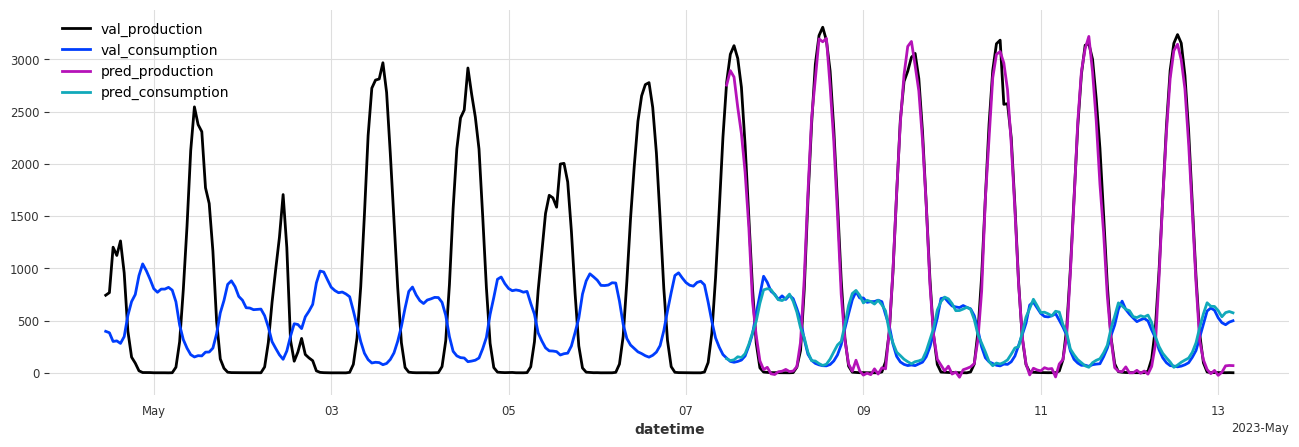

In [59]:
prediction = model_TiDE_optim.predict(
    prediction_len, val_target[:-prediction_len],
    past_covariates=val_past_covariates,
    future_covariates=val_future_covariates,
)

plt.figure(figsize=(16, 5))

val_target.plot(label="val")
prediction.plot(label="pred")
plt.show()

In [60]:
all_results['TiDE_optimized'] = get_results(val_target[IN_LEN:], prediction)

Overall MAE:  53.35003618904331
Consumption MAE:  37.012054761686436
Production MAE:  69.68801761640017


Predicting: 0it [00:00, ?it/s]

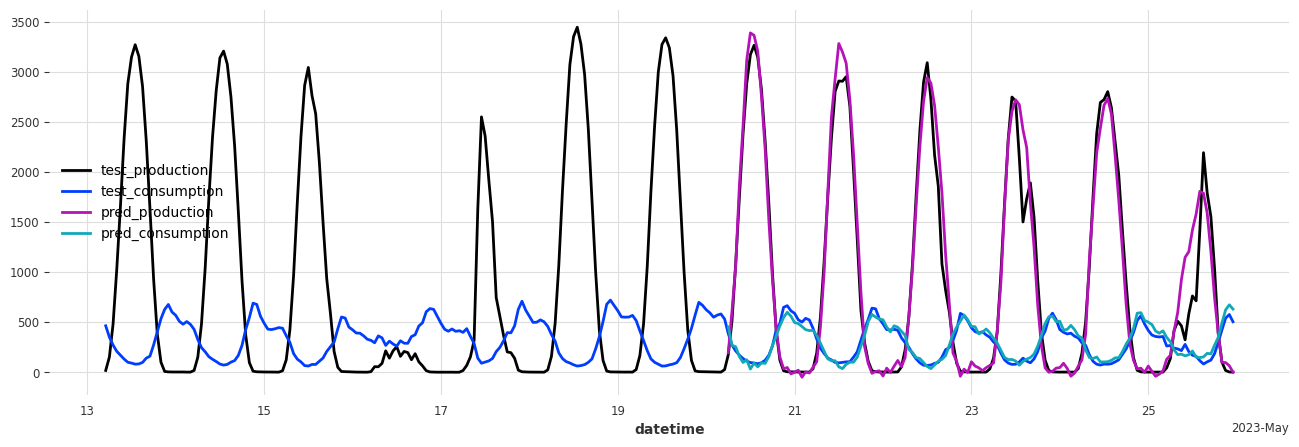

In [73]:
prediction = model_TiDE_optim.predict(
    prediction_len, test_target[:-prediction_len],
    past_covariates=test_past_covariates,
    future_covariates=test_future_covariates,
)

plt.figure(figsize=(16, 5))

test_target.plot(label="test")
prediction.plot(label="pred")
plt.show()

In [75]:
all_results['TiDE_optimized_test'] = get_results(test_target[IN_LEN:], prediction)

Overall MAE:  88.02093471445012
Consumption MAE:  42.17396003284224
Production MAE:  133.867909396058


In [76]:
pd.DataFrame(all_results)

,TiDE_default,TiDE_optimized,TiDE_optimized_test,TiDE_default_test
overall_MAE,66.873529,53.350036,88.020935,91.103697
consumption_MAE,31.793943,37.012055,42.173960,39.209828
production_MAE,101.953115,69.688018,133.867909,142.997565


Interestingly, altough the overall MAE is better for optimized TiDE, the consumption MAE is worse. This suggests that the model may have difficulty with multivariate prediction. Also, for both default and optimized TiDE, the test results are worse than validation results.

"multivariate models are typically worse than the univariate ones, the reason being the difficulty in estimating the cross-series correlations/relationships" - https://huggingface.co/blog/autoformer